In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.simplefilter("ignore")

### I could build this into script-only, output-a-report, log-to-favourite-expt-tracking-solution, but...
<br>I still just want to iterate quickly and play around with different options, so I'll do it in a notebook

In [2]:
from trainer import CensusTrainer
import copy
import json

In [3]:
with open("census_data_col_names.json", "r") as f:
    column_names = json.load(f)
df_test = pd.read_csv("census_income_test.csv", names=column_names)
df_train = pd.read_csv("census_income_learn.csv", names=column_names)

### first pass, expressing the "feature engineering decisions" from EDA notebook into a config:

In [4]:
scale = False
rf_process_config = {}
for feat in ["age", "wage_per_hour", "capital_gains", "capital_losses", "dividends_from_stocks", "num_persons_worked_for_employer", "weeks_worked_in_year"]:
    rf_process_config[feat] = {"processor": "numeric",
                               "kwargs": {"scale": scale}}
    
rf_process_config |= {
    "class_of_worker": {"processor": "binary_flag",
                        "args": [["Not in universe"]],
                        "kwargs": {"scale": scale,
                                   "new_feature_name": "worker_not_in_class_universe"}},
    
    "detailed_industry_recode": {"processor": "binary_flag",
                                 "args": [["0"]],
                                 "kwargs": {"scale": scale,
                                            "new_feature_name": "works_in_agriculture_industry"}},
    
    "education": {"processor": "binary_flag",
                  "args": [["Bachelors degree(BA AB BS)", "Doctorate degree(PhD EdD)", "Masters degree(MA MS MEng MEd MSW MBA)", "Prof school degree (MD DDS DVM LLB JD)"]],
                  "kwargs": {"scale": scale,
                             "new_feature_name": "has_higher_education"}},
    
    "enroll_in_edu_inst_last_wk": {"processor": "binary_flag",
                                   "args": [["College or university", "High school"]],
                                   "kwargs": {"scale": scale,
                                              "new_feature_name": "still_in_education"}},
    
    "marital_stat": {"processor": "ordinal",
                     "args": [{2: ["Married-civilian spouse present"],
                               0: ["Never married"]}],
                     "kwargs": {"unspecified_categoricals_value": 1,
                                "scale": scale,
                                "new_feature_name": "never_married__other__married_(Lo-Hi)"}},
    
    "major_industry_code": {"processor": "binary_flag",
                            "args": [["Not in universe or children"]],
                            "kwargs": {"scale": scale,
                                       "new_feature_name": "child_or_industry_unknown"}},
    
    "sex": {"processor": "binary_flag",
            "args": [["Male"]],
            "kwargs": {"scale": scale,
                       "new_feature_name": "individual_is_male"}},
    
    "full_or_part_time_employment_stat": {"processor": "ordinal",
                                          "args": [{2: ["Full-time schedules"],
                                                    0: ["Children or Armed Forces", "Not in labor force"]}],
                                          "kwargs": {"unspecified_categoricals_value": 1,
                                                     "scale": scale,
                                                     "new_feature_name": "nolabour_forces_child__other__fulltime_(Lo-Hi)"}},
    
    "tax_filer_stat": {"processor": "ordinal",
                       "args": [{2: ["Joint both under 65"],
                                 0: ["Nonfiler"]}],
                       "kwargs": {"unspecified_categoricals_value": 1,
                                  "scale": scale,
                                  "new_feature_name": "non_tax_filer__other__joint_worker_filers_(Lo-Hi)"}},
    
    "detailed_household_summary_in_household": {"processor": "ordinal",
                                                "args": [{2: ["Householder"],
                                                          0: ["Child 18 or older", "Child under 18 never married", "Child under 18 ever married"]}],
                                                "kwargs": {"unspecified_categoricals_value": 1,
                                                           "scale": scale,
                                                           "new_feature_name": "child_w_parents__other__main_householder_(Lo-Hi)"}},
    
    "country_of_birth_mother": {"processor": "binary_flag",
                                "args": [["Mexico", "Puerto-Rico"]],
                                "kwargs": {"scale": scale,
                                           "new_feature_name": "mother_born_in_mexico_or_puerto_rico"}},
}

# Tried saving and reloading this, but there is a but in the code/method -- saving/loading changed keys from int to str, which causes issues. This is why we test!

### Experiment time!

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     37523
           1       0.29      0.88      0.43      2422

    accuracy                           0.86     39945
   macro avg       0.64      0.87      0.68     39945
weighted avg       0.95      0.86      0.89     39945

AUC score: 0.944


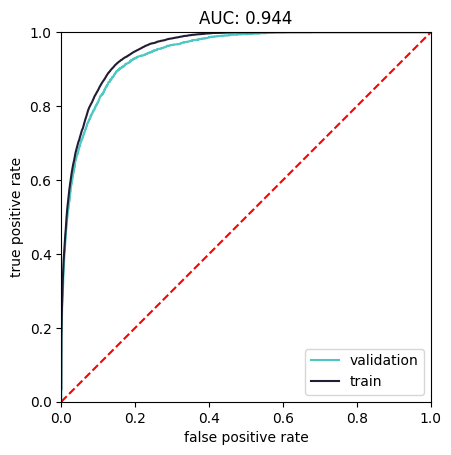

In [8]:
trainer = CensusTrainer(df_train,
                       {"preprocessing": rf_process_config,
                        "train": {"classifier": "XGBClassifier",
                                  "n_estimators": 64,
                                  "learning_rate": 0.3,},
                        "experiment_name": "XGBC_v0.0.0"})

trainer.preprocess_data()
trainer.train_classifier()
trainer.evaluate_classifier()

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     37523
           1       0.29      0.85      0.43      2422

    accuracy                           0.86     39945
   macro avg       0.64      0.86      0.67     39945
weighted avg       0.95      0.86      0.89     39945

AUC score: 0.936


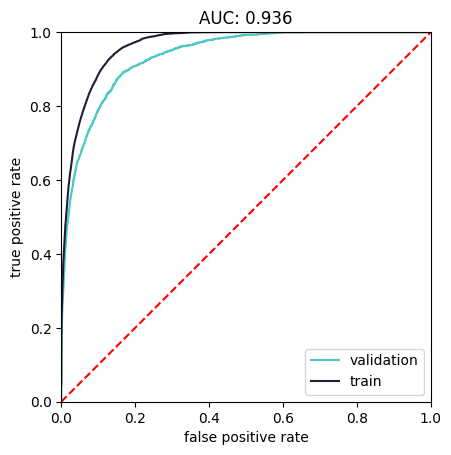

In [6]:
trainer = CensusTrainer(df_train,
                       {"preprocessing": rf_process_config,
                        "train": {"classifier": "XGBClassifier",
                                  "n_estimators": 64,
                                  "learning_rate": 1,}, # changed
                        "experiment_name": "XGBC_v0.0.1"})

trainer.preprocess_data()
trainer.train_classifier()
trainer.evaluate_classifier()

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     37523
           1       0.27      0.90      0.42      2422

    accuracy                           0.85     39945
   macro avg       0.63      0.87      0.66     39945
weighted avg       0.95      0.85      0.88     39945

AUC score: 0.944


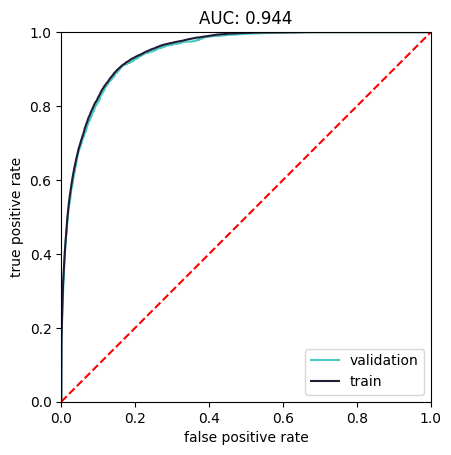

In [7]:
trainer = CensusTrainer(df_train,
                       {"preprocessing": rf_process_config,
                        "train": {"classifier": "XGBClassifier",
                                  "n_estimators": 64,
                                  "learning_rate": 0.1,}, # changed
                        "experiment_name": "XGBC_v0.0.2"})

trainer.preprocess_data()
trainer.train_classifier()
trainer.evaluate_classifier()

In [9]:
# XGBC_v0.0.0 was best... let's test that
trainer.experiment_name

'XGBC_v0.0.0'

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     93576
           1       0.29      0.89      0.43      6186

    accuracy                           0.86     99762
   macro avg       0.64      0.87      0.68     99762
weighted avg       0.95      0.86      0.89     99762

Test AUC score: 0.945


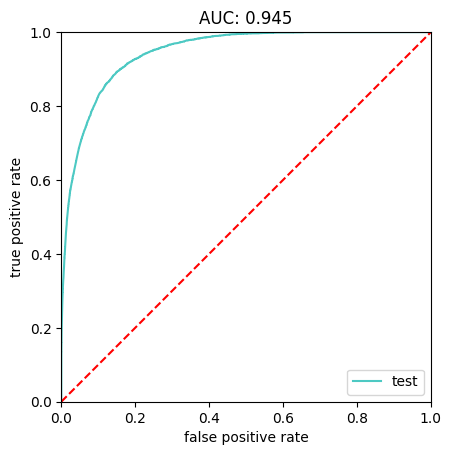

In [10]:
trainer.evaluate_on_unseen_dataset(df_test)

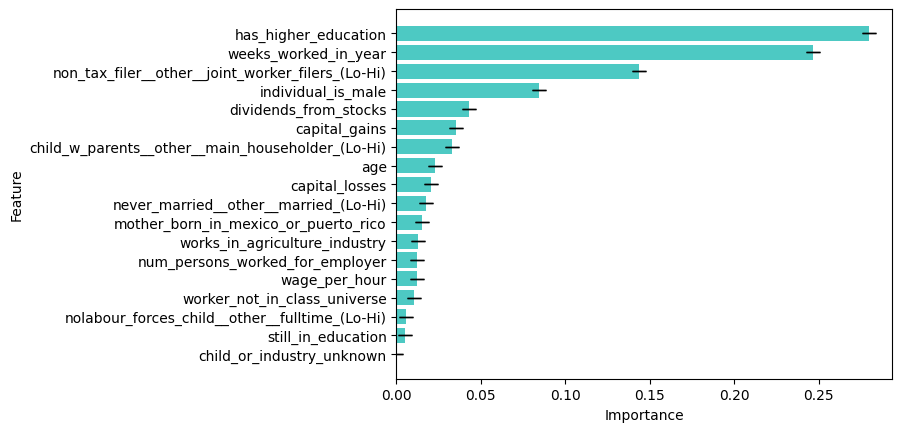

In [11]:
trainer.get_feature_importances()

### I'm also a little curious to try XGB Random Forest...

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     37523
           1       0.27      0.88      0.41      2422

    accuracy                           0.85     39945
   macro avg       0.63      0.86      0.66     39945
weighted avg       0.95      0.85      0.88     39945

AUC score: 0.939


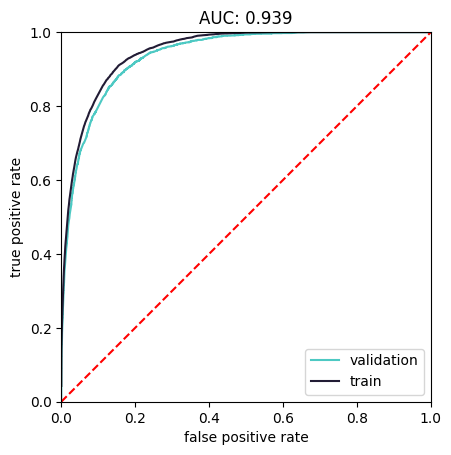

In [17]:
trainer2 = CensusTrainer(df_train,
                        {"preprocessing": rf_process_config,
                         "train": {"classifier": "XGBRFClassifier",
                                   "n_estimators": 128,
                                   "max_depth": 10,
                                   "learning_rate": 0.3,},
                         "experiment_name": "XGBRF_v0.0.0"})

trainer2.preprocess_data()
trainer2.train_classifier()
trainer2.evaluate_classifier()

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     37523
           1       0.30      0.83      0.44      2422

    accuracy                           0.87     39945
   macro avg       0.64      0.85      0.68     39945
weighted avg       0.95      0.87      0.90     39945

AUC score: 0.935


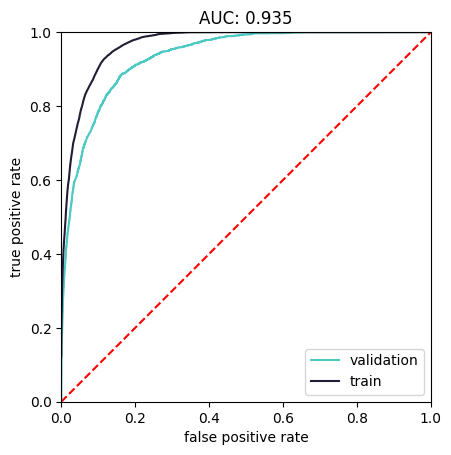

In [13]:
trainer2 = CensusTrainer(df_train,
                        {"preprocessing": rf_process_config,
                         "train": {"classifier": "XGBRFClassifier",
                                   "n_estimators": 128,
                                   "max_depth": 15,  # changed
                                   "learning_rate": 0.3,},
                         "experiment_name": "XGBRF_v0.0.1"})

trainer2.preprocess_data()
trainer2.train_classifier()
trainer2.evaluate_classifier()

              precision    recall  f1-score   support

           0       0.99      0.82      0.90     37523
           1       0.25      0.90      0.39      2422

    accuracy                           0.83     39945
   macro avg       0.62      0.86      0.64     39945
weighted avg       0.95      0.83      0.87     39945

AUC score: 0.937


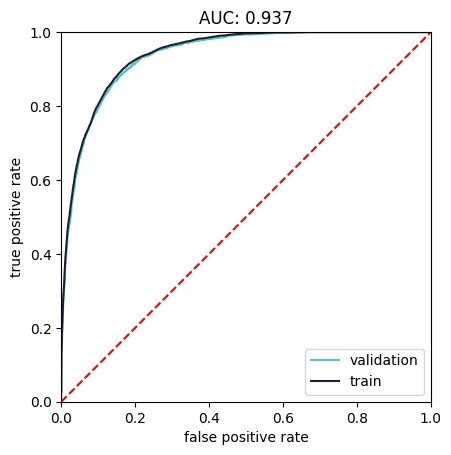

In [14]:
trainer2 = CensusTrainer(df_train,
                        {"preprocessing": rf_process_config,
                         "train": {"classifier": "XGBRFClassifier",
                                   "n_estimators": 128,
                                   "max_depth": 8,  # changed
                                   "learning_rate": 0.3,},
                         "experiment_name": "XGBRF_v0.0.2"})

trainer2.preprocess_data()
trainer2.train_classifier()
trainer2.evaluate_classifier()

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     37523
           1       0.27      0.88      0.41      2422

    accuracy                           0.85     39945
   macro avg       0.63      0.86      0.66     39945
weighted avg       0.95      0.85      0.88     39945

AUC score: 0.939


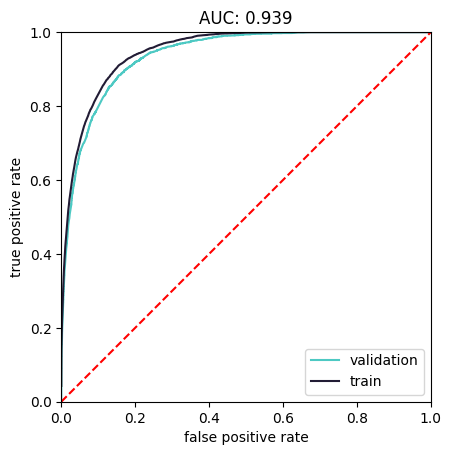

In [15]:
trainer2 = CensusTrainer(df_train,
                        {"preprocessing": rf_process_config,
                         "train": {"classifier": "XGBRFClassifier",
                                   "n_estimators": 128,
                                   "max_depth": 10,  # reverted
                                   "learning_rate": 1,}, # changed
                         "experiment_name": "XGBRF_v0.0.3"})

trainer2.preprocess_data()
trainer2.train_classifier()
trainer2.evaluate_classifier()

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     37523
           1       0.27      0.88      0.41      2422

    accuracy                           0.85     39945
   macro avg       0.63      0.86      0.66     39945
weighted avg       0.95      0.85      0.88     39945

AUC score: 0.939


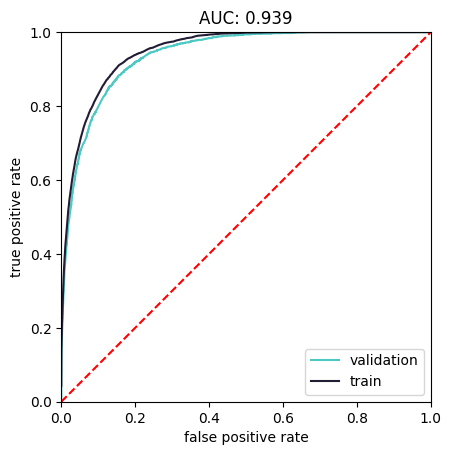

In [16]:
trainer2 = CensusTrainer(df_train,
                        {"preprocessing": rf_process_config,
                         "train": {"classifier": "XGBRFClassifier",
                                   "n_estimators": 128,
                                   "max_depth": 10,  # reverted
                                   "learning_rate": 2,}, # changed
                         "experiment_name": "XGBRF_v0.0.4"})

trainer2.preprocess_data()
trainer2.train_classifier()
trainer2.evaluate_classifier()

### Levers not making much difference here either. Should really revisit feature engineering

In [18]:
# Let's just revisit the first one, XGBRF_v0.0.0
trainer2.experiment_name

'XGBRF_v0.0.0'

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     93576
           1       0.27      0.88      0.41      6186

    accuracy                           0.84     99762
   macro avg       0.63      0.86      0.66     99762
weighted avg       0.95      0.84      0.88     99762

Test AUC score: 0.939


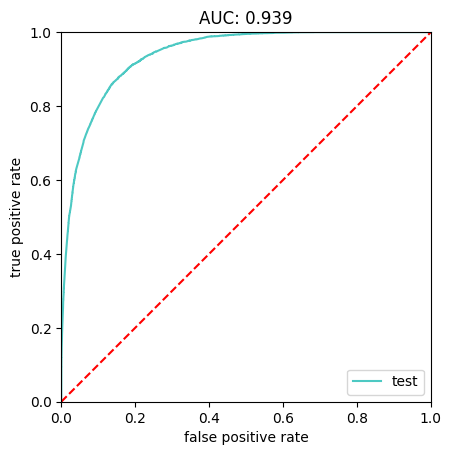

In [19]:
trainer2.evaluate_on_unseen_dataset(df_test)

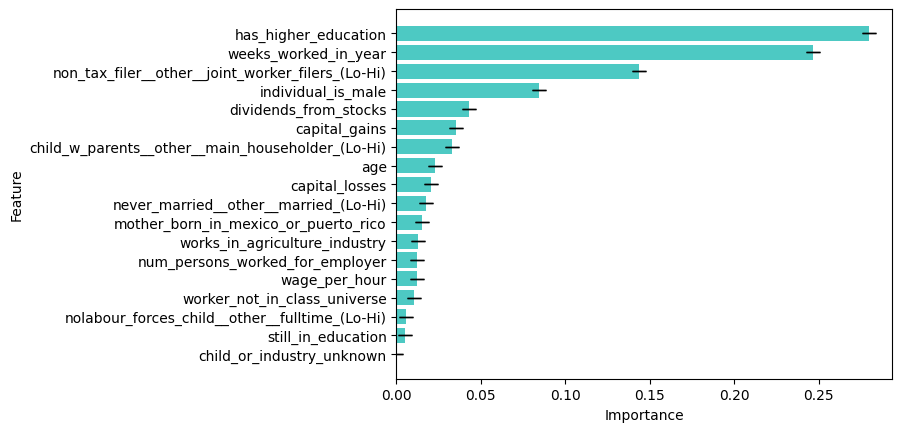

In [20]:
trainer.get_feature_importances()

After playing around with some hyperparameters... I'm a little disappointed it doesn't do better. I guess its strength possibly comes from treatment of categoricals, but I've not built the framework around that, so won't be trying it here... some other time!